# DATA2001 Assingment 3: Forecasting

# Contents

1. Data Preparation
2. EDA
3. Seasonal-Trend decomposition
4. ARIMA Model
5. LSTM Model
6. Model Evaluation  

## Data Preparation

Data is US Amazon stock prices from 21 year period begining in 1997. 

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data from remote link
df = pd.read_csv("https://raw.githubusercontent.com/benisrael29/data-sets/main/amzn.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Display the first 5 rows
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [56]:
print(type(df['Date'][2])) 

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


**Exogenous Data: VIX Index**

"Volatility Index, a popular measure of the stock market's expectation of volatility based on S&P 500 index options. It is calculated and disseminated on a real-time basis by the CBOE, and is often referred to as the fear index or fear gauge." Source: [Wikipedia](https://en.wikipedia.org/wiki/VIX)

It is useful exogenous variable because it gives a broad sense of the state the world in relation to the market. It is highly correlated to news events that are expected to negativly effect markets. In this case it is presented as a 30-day expection of volatility given a weighted portfolio of european options on the S&P 500. Its sourced from  [Yahoo Finance](https://finance.yahoo.com/quote/%5EVIX?p=%5EVIX) for the relevant period. 

In [57]:
vix = pd.read_csv('https://raw.githubusercontent.com/benisrael29/data-sets/main/VIX.csv')
vix.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-16,18.730000,21.820000,18.580000,21.570000,21.570000,0
1,1997-05-19,21.879999,21.950001,21.260000,21.480000,21.480000,0
2,1997-05-20,21.490000,21.719999,19.129999,19.260000,19.260000,0
3,1997-05-21,19.190001,19.620001,18.820000,19.280001,19.280001,0
4,1997-05-22,19.010000,19.240000,18.680000,18.770000,18.770000,0


In [58]:
#Dropping unneeded columns and keeping close for merge with amazon dataset
vix=vix['Close']
vix = vix.rename('VIXClose')
df['VIX Close']= vix

# Exploratory Analysis


## VIX

<AxesSubplot:>

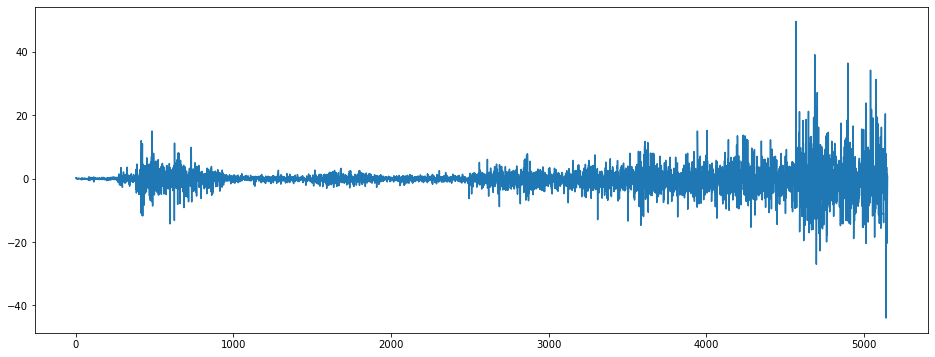

In [59]:
# Plot the differance be between open and close prices
df['Open-Close'] = df.Open - df.Close
df['Open-Close'].plot(figsize=(16,6))


Graph of the differance in open and close prices shows higher levels of intr-day volatility in the last quarter of the data. 

Text(0, 0.5, 'Volume Traded')

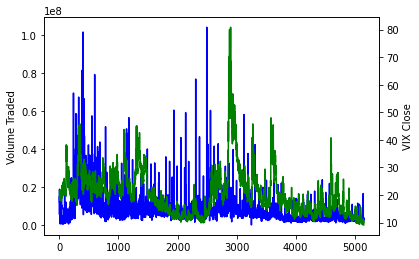

In [60]:
#Plot VIX and volume traded on same graph with different y axis
ax = df['VIX Close'].plot(secondary_y=True, color='g')
df['Volume'].plot(ax=ax, color='b')
ax.set_ylabel('VIX Close')
ax.left_ax.set_ylabel('Volume Traded')


Hard to distinguish a visible pattern but there does appear to be some correlation between the two. 

Text(0, 0.5, 'Open-Close')

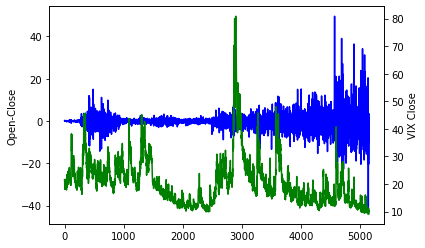

In [61]:
#Plot the VIX and the open-close price on the same graph
ax = df['VIX Close'].plot(secondary_y=True, color='g')
df['Open-Close'].plot(ax=ax, color='b')
ax.set_ylabel('VIX Close')
ax.left_ax.set_ylabel('Open-Close')


VIX doesnt seem to have a great effect on intra-day volatility. 

### Effect of the GFC on Price and Volume

In [62]:
# Get the date of max VIX Close
df['Date'][df['VIX Close'].idxmax()]

Timestamp('2008-11-28 00:00:00')

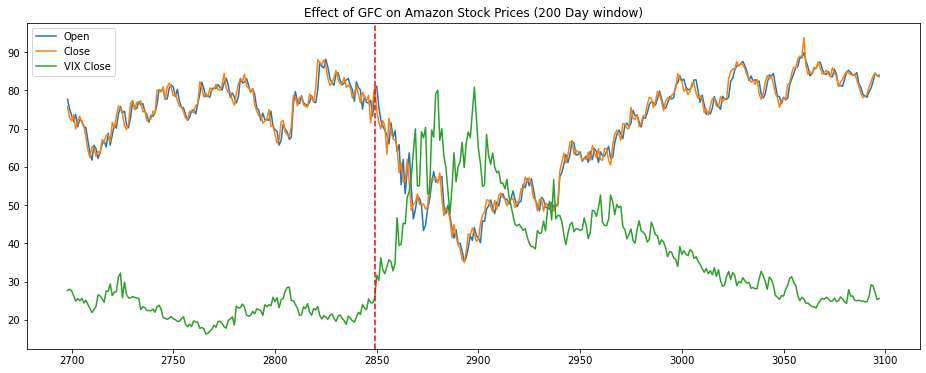

In [63]:
#Plot open and close and vix close on same graph with legend
df[['Open','Close','VIX Close']].iloc[2698:3098].plot(figsize=(16,6))

# Add title
plt.title('Effect of GFC on Amazon Stock Prices (200 Day window)')

#Plot line at 2849
plt.axvline(x=2849, color='r', linestyle='--')

It does appear the GFC had an impact on price but its also clear that over the preceeding 200 days the price was able to recover. The red line in this graph represents the trading day of 17th Sep 2018 considered the worest day of the GFC where $144 billion was withdraw from US markets. 

## Other Variables

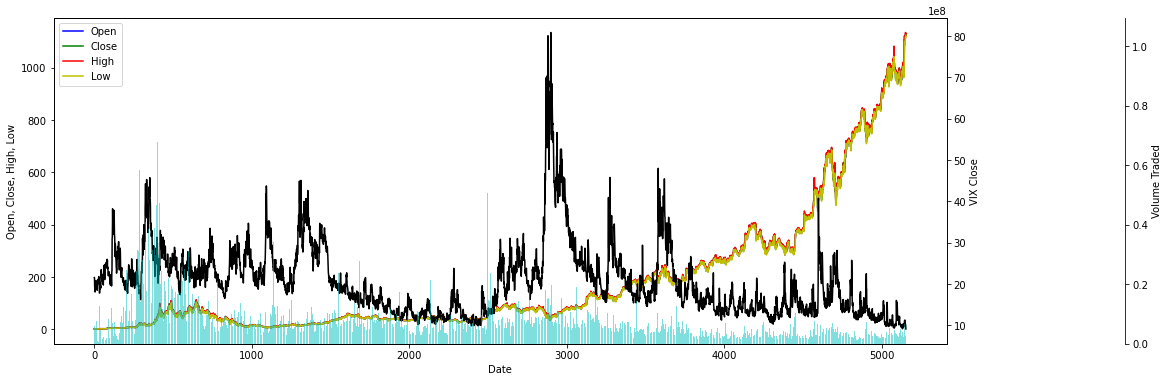

In [64]:
#Plot open, close, high, low on one axis and VIX close on another axis. Plot volume under the graph
fig, ax1 = plt.subplots(figsize=(16,6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax1.plot(df['Open'], color='b')
ax1.plot(df['Close'], color='g')
ax1.plot(df['High'], color='r')
ax1.plot(df['Low'], color='y')
ax2.plot(df['VIX Close'], color='k')
ax3.bar(df.index, df['Volume'], color='c', alpha=0.5)
ax1.set_ylabel('Open, Close, High, Low')
ax2.set_ylabel('VIX Close')
ax3.set_ylabel('Volume Traded')
ax1.set_xlabel('Date')

#Add legend
ax1.legend(['Open', 'Close', 'High', 'Low', 'VIX Close', 'Volume Traded'])

Price appears to expentially grow, with a sharp increase beginning around 2010. Volume does not have a discernable pattern in this graph. 

# Decomposition 

In [65]:
# Split data into training and test sets
train = df.iloc[:5081,:]
test = df.iloc[5081:,:]

### Isolating Trend

<ipython-input-66-9620078d5121>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['MA-60'] = train['Volume'].rolling(60).mean()
<ipython-input-66-9620078d5121>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['MA-120'] = train['Volume'].rolling(120).mean()


<AxesSubplot:>

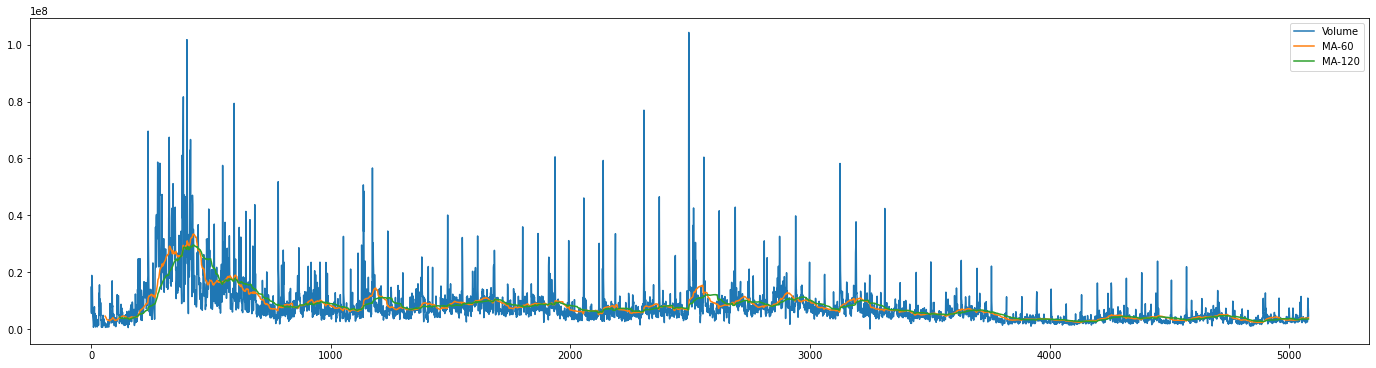

In [66]:
# There are 5 observations per week
train['MA-60'] = train['Volume'].rolling(60).mean()
train['MA-120'] = train['Volume'].rolling(120).mean()

train[['Volume','MA-60','MA-120']].plot(figsize=(24,6))

The MA-120 appears to be too long. You can determine this by observings the effect big changes have on it and how it appears to 'lag' a little more then MA-60.


### De-trending

<ipython-input-67-d74d21a33dd1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vol-detrended'] = train['Volume'] - train['MA-120']


<AxesSubplot:>

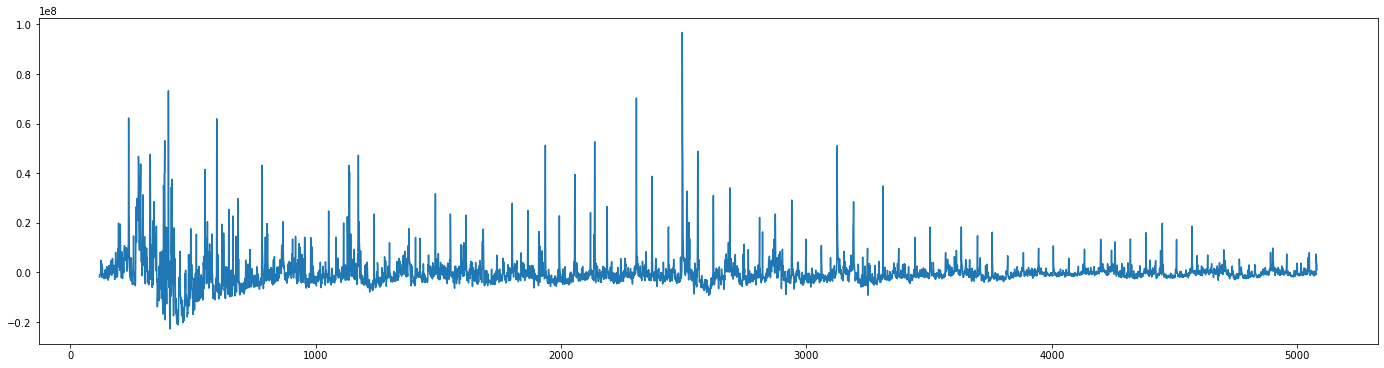

In [67]:
train['vol-detrended'] = train['Volume'] - train['MA-120']
train['vol-detrended'].plot(figsize=(24,6))

### Seasonality Component 

<ipython-input-68-bd653a9a0ad6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vol-seasonal'] = result._seasonal


<AxesSubplot:>

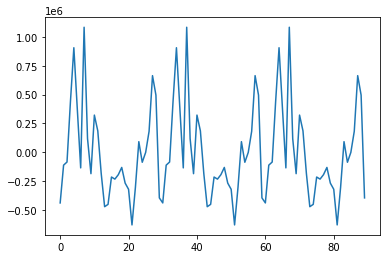

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['Volume'], model='additive',period=30)

train['vol-seasonal'] = result._seasonal
result._seasonal[:90].plot()

### Residual

<ipython-input-69-4f3e7f87d264>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vol-residual'] = train['vol-detrended'] - train['vol-seasonal']


<AxesSubplot:>

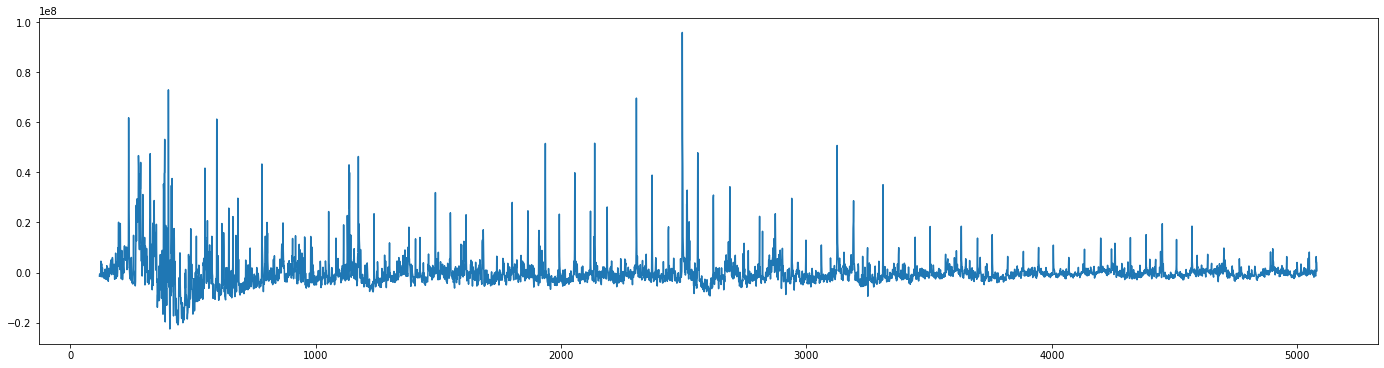

In [69]:
train['vol-residual'] = train['vol-detrended'] - train['vol-seasonal']
train['vol-residual'].plot(figsize=(24,6))

### Manual Decomposition Results


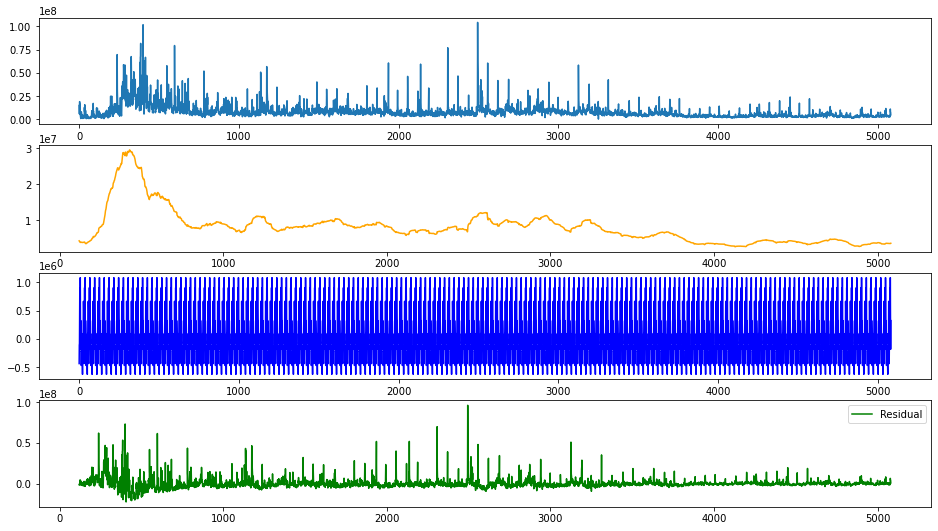

In [70]:
import matplotlib.pyplot as plt
fig, ax_str = plt.subplots(4)
train['Volume'].plot(label='Original', ax=ax_str[0])
train['MA-120'].plot(color='orange', label='MA-120 Trend', ax=ax_str[1])
train['vol-seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
train['vol-residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

### Automatic Decomposition  

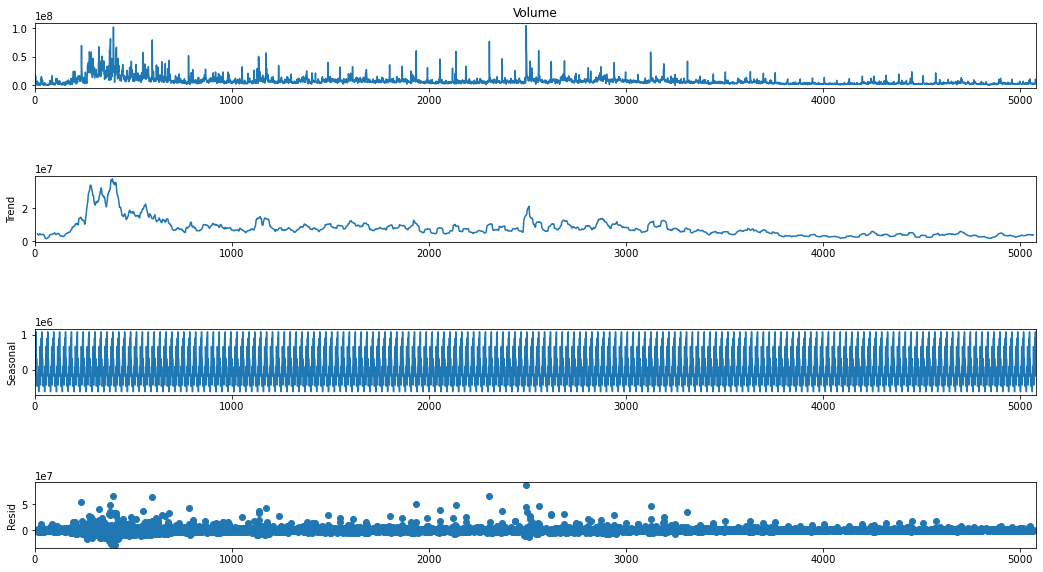

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

str_res = seasonal_decompose(train['Volume'],period = 30)
fig = str_res.plot()
fig.set_size_inches((16, 9))

### Manual vs Automatic Decomposition

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt',
       'VIX Close', 'Open-Close', 'MA-60', 'MA-120', 'vol-detrended',
       'vol-seasonal', 'vol-residual'],
      dtype='object')


<Figure size 1440x720 with 0 Axes>

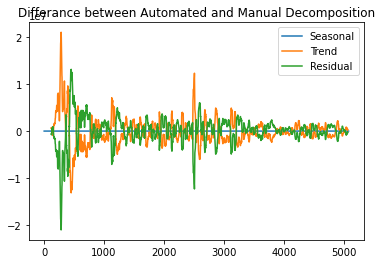

<Figure size 1440x720 with 0 Axes>

In [72]:
#Compare str_res to train
#Print column headings of train
print(train.columns)

#calculate differance between str_res.seasonal and train.vol-seasonal
diff_seasonal = str_res.seasonal - train['vol-seasonal']

#calculate differance between str_res.trend and train MA-120
diff_trend = str_res.trend - train['MA-120']

#calculate differance between str_res.resid and train.vol-residual
diff_resid = str_res.resid - train['vol-residual']

#Plot the differances with labels
diff_seasonal.plot(label='Seasonal')
diff_trend.plot(label='Trend')
diff_resid.plot(label='Residual')
plt.legend()

plt.title('Differance between Automated and Manual Decomposition')

#Make plot larger
plt.figure(figsize=(20,10))

In [73]:
#Calculate the error between str_res.seasonal and train.vol-seasonal
error_seasonal = np.sqrt(np.mean((str_res.seasonal - train['vol-seasonal'])**2))

#Calculate the error between str_res.trend and train MA-120
error_trend = np.sqrt(np.mean((str_res.trend - train['MA-120'])**2))

#Calculate the error between str_res.resid and train.vol-residual
error_resid = np.sqrt(np.mean((str_res.resid - train['vol-residual'])**2))

#Print the errors
print('Seasonal Error:', error_seasonal)
print('Trend Error:', error_trend)
print('Residual Error:', error_resid)

print('--------------------------------------')
#Calculate errors as a percentage of the mean
print('Seasonal Error as % of Mean:', error_seasonal/np.mean(train['Volume'])*100)
print('Trend Error as % of Mean:', error_trend/np.mean(train['Volume'])*100)
print('Residual Error as % of Mean:', error_resid/np.mean(train['Volume'])*100)

Seasonal Error: 0.0
Trend Error: 2914295.719526824
Residual Error: 2914295.7195268245
--------------------------------------
Seasonal Error as % of Mean: 0.0
Trend Error as % of Mean: 36.88476536583896
Residual Error as % of Mean: 36.88476536583896


### Format the data for models

In [74]:
df.drop('OpenInt', axis=1) # OpenInt is a constant column

#Overite the original dataframe with the automatic decomposition
str_res = seasonal_decompose(df['Volume'],period = 30)

data = str_res.observed.to_frame()
data['seasonal'] = str_res.seasonal
data['trend']=str_res.trend
data['res']=str_res.resid
data['obs']=str_res.observed

train = data.iloc[:5081,:]
test = data.iloc[5081:,:]

# ARIMA Model

### Stationarity?

Data needs to be stationary for ARIMA to be accurate. This means that it is:
- has a constant variance 
- patternless over time 
- roughly horizontal 

<AxesSubplot:>

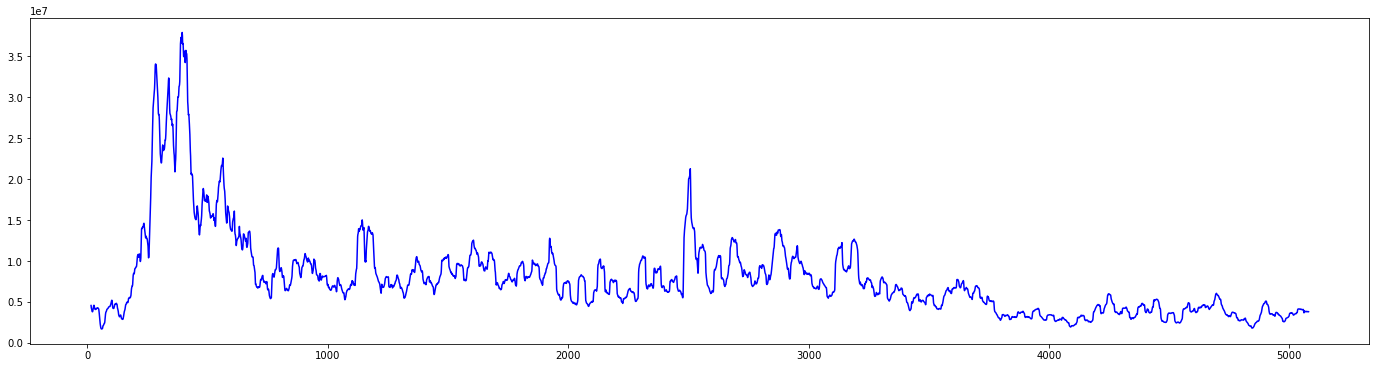

In [75]:
m_data =train['trend']
m_data.plot(color='blue', figsize=(24,6))

#### Augmented Dicky Fuller test

An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. [Wikipedia](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test)

The null hypothesis indicates non stationarity. The alternative hypothesis indicates stationarity. 

In [76]:
#Check if m_data is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(m_data.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -2.552316
p-value: 0.103258
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Since the p value is greater than 0.05 the null hypothsis cannot be rejected and this data is non stationary.   

<AxesSubplot:>

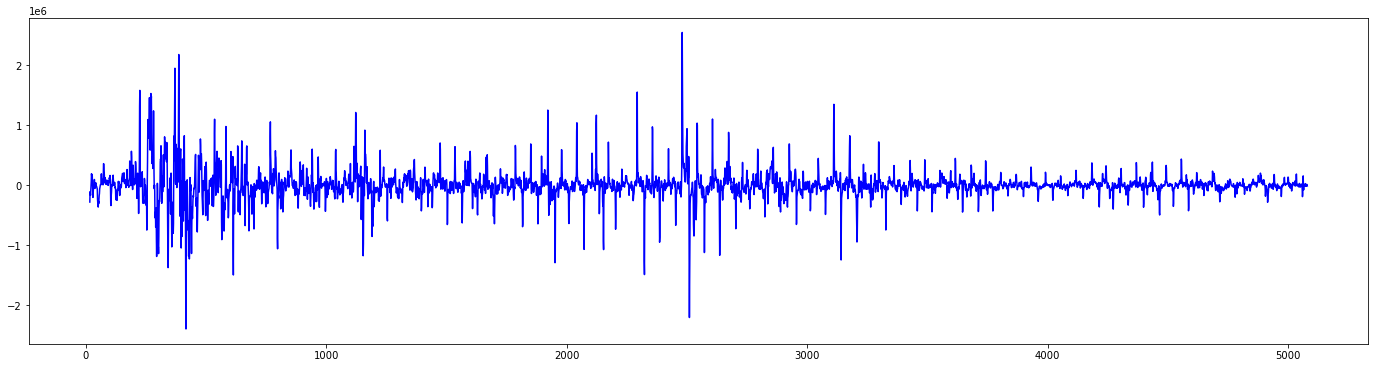

In [77]:
#Make data stationary
m_data_diff = m_data.diff().dropna()
m_data_diff.plot(color='blue', figsize=(24,6))


In [78]:
#Check if m_data_diff is stationary
result = adfuller(m_data_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -16.976881
p-value: 0.000000


Data is now stationary. 

In [79]:
m_data = m_data_diff

### Fit Model

In [80]:
# Some tools 

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

#### Autocorrelations

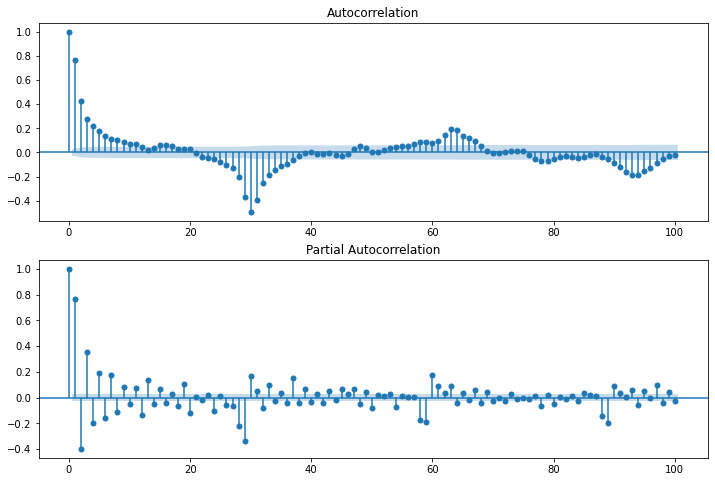

In [81]:
m_data = m_data.dropna()
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(m_data, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(m_data, lags=100, ax=ax2)

### Fit Model
The arima model is a combination of both the AR and MA terms. 

The model takes (p,d,q) where:

- p is the order of the model.
- d is the differance order. Which we will leave as 0 as we have already ensured the data is stationary. 
- p is the order of the moving average

In [82]:
arima_1_0_0 = ARIMA(m_data, order=(1, 0, 0)).fit()
print(arima_1_0_0.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                 5065
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -67847.215
Date:                Sat, 05 Nov 2022   AIC                         135700.431
Time:                        18:24:48   BIC                         135720.021
Sample:                             0   HQIC                        135707.292
                               - 5065                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -148.9145   9718.332     -0.015      0.988   -1.92e+04    1.89e+04
ar.L1          0.7700      0.003    226.845      0.000       0.763       0.777
sigma2      2.526e+10      0.020   1.26e+12      0.0

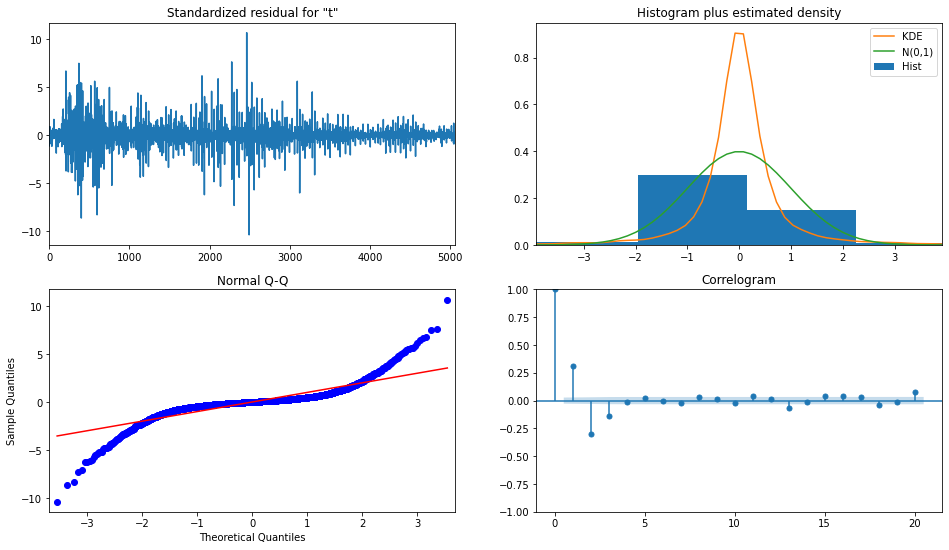

In [83]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_0_0.plot_diagnostics(fig=fig, lags=20)

In [84]:
arima_2_0_1 = ARIMA(m_data, order=(2, 0, 1)).fit()
print(arima_2_0_1.summary())


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                 5065
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -66501.404
Date:                Sat, 05 Nov 2022   AIC                         133012.807
Time:                        18:24:53   BIC                         133045.458
Sample:                             0   HQIC                        133024.243
                               - 5065                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -148.9145   9535.167     -0.016      0.988   -1.88e+04    1.85e+04
ar.L1          0.5315      0.011     50.222      0.000       0.511       0.552
ar.L2          0.0086      0.011      0.793      0.4

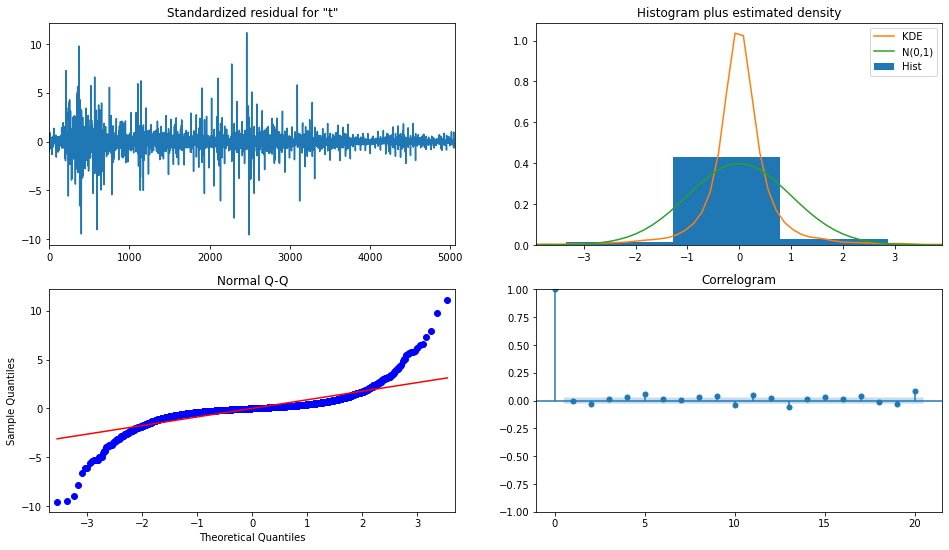

In [85]:
fig = plt.figure(figsize=(16, 9))
fig = arima_2_0_1.plot_diagnostics(fig=fig, lags=20)

In [86]:
#Compare the two models with AIC and BIC
print('Differance of AIC:', arima_1_0_0.aic - arima_2_0_1.aic)
print('Differance of BIC:', arima_1_0_0.bic - arima_2_0_1.bic)

Differance of AIC: 2687.6232024747005
Differance of BIC: 2674.5629836413427


AIC and BIC are measures of the models fit. ARIMA(2,0,1) as lower values for both.  The co-efficent of the moving average term is highly significant.  


### Forcast with ARIMA

In [87]:
arima_fcst = arima_2_0_1.get_forecast(steps=72)
arima_predictions = pd.DataFrame(arima_fcst.predicted_mean)
arima_predictions.rename(columns={"predicted_mean": "trend"}, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [88]:
#Select the 5000 to 5065 rows of m_data
plot_data = m_data.iloc[4985:5050]

In [89]:
#Get arima confidence intervals
arima_ci = arima_fcst.conf_int()

<Figure size 1440x720 with 0 Axes>

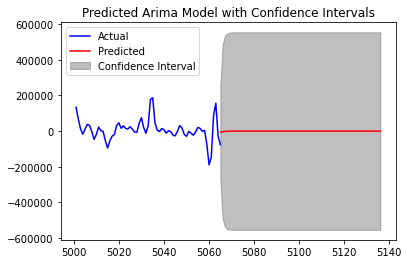

<Figure size 1440x720 with 0 Axes>

In [90]:
#Plot m_data values 5000 to 5065 and arima_predictions on the same plot with confidence intervals
plot_data.plot(color='blue', label='Actual')
arima_predictions['trend'].plot(color='red', label='Predicted')

#Add confidence intervals
plt.fill_between(arima_predictions.index, arima_ci['upper trend'], arima_ci['lower trend'], color='k', alpha=.25, label='Confidence Interval')

plt.title('Predicted Arima Model with Confidence Intervals')
plt.legend( loc='upper left')
plt.figure(figsize=(20,10))


In [91]:
#Get the last volume value in train
last_vol = train['Volume'].iloc[-1]
#turn arama_predictions into a numpy array
predsss = arima_predictions.to_numpy().reshape((72,))

In [92]:
reversed_differance = np.r_[last_vol, predsss].cumsum()

arima_predictions = reversed_differance

#Add index to predictions starting at 5081
arima_predictions = pd.DataFrame(arima_predictions, index=range(5080, 5153))

# Pure Forecaster: LSTM

LSTM stands for long short-term memory networks. They are designed for sequentail prediction which is what time series forcasting is simplified to. Unlike other ML models LSTMs are have feedback connections. Each unit comprises three fates which control the flow of information. The unit structure can be seen here: ![](https://upload.wikimedia.org/wikipedia/commons/9/93/LSTM_Cell.svg) [Source](https://upload.wikimedia.org/wikipedia/commons/9/93/LSTM_Cell.svg)

In [107]:
#Get some tools
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [108]:
nn_data = train['trend'].dropna()
nn_data.values

array([4554020.        , 4274560.        , 4167900.        , ...,
       3805169.8       , 3810011.18333333, 3799767.93333333])

In [109]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
nn_data = scaler.fit_transform(np.array(nn_data).reshape(-1, 1))

In [110]:
x_train = []
y_train = []

#Split the data into train and test
for i in range(60, len(nn_data)):
    x_train.append(nn_data[i-60:i, 0])
    y_train.append(nn_data[i, 0])


In [111]:
#Convert the data into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [112]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [113]:
#Create the model
def create_LSTM_forcastor(x_train, batch_size, epochs):
    model = Sequential()
    model.add(LSTM(units=200, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=200, return_sequences=True))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    model.fit(x_train, y_train, epochs, batch_size, verbose=1)
    return model

#model takes a minute to train
model=create_LSTM_forcastor(x_train, 1, 1)


5006/5006 [==============================] - 504s 99ms/step - loss: 0.0089


In [129]:
test_data = test['trend'].values
test_data = scaler.transform(np.array(test_data).reshape(-1, 1))

#Create our test datasets
x_test = []
y_test = test_data

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


In [130]:
x_test = np.array(x_test)

In [131]:
#LSTM models take 3D data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Lets predict
predictions = model.predict(x_test)
predictions = predictions.reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)


1/1 [==============================] - 0s 212ms/step


In [132]:
y_test = y_test[~np.isnan(y_test)]
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [133]:
#Root mean squared error of the model predictions
rmse = math.sqrt(np.mean(((predictions[:y_test.shape[0]]- y_test)**2)))
print(rmse)

1274761.717624648


In [134]:
#Convert numpy array to pandas dataframe
df_predictions = pd.DataFrame(predictions, columns=['trend'])

df_predictions.set_index([pd.Index(range(train.shape[0], train.shape[0]+df_predictions.shape[0]))], inplace=True)

df_y_test = pd.DataFrame(y_test, columns=['trend'])
df_y_test.set_index([pd.Index(range(train.shape[0], train.shape[0]+df_y_test.shape[0]))], inplace=True)

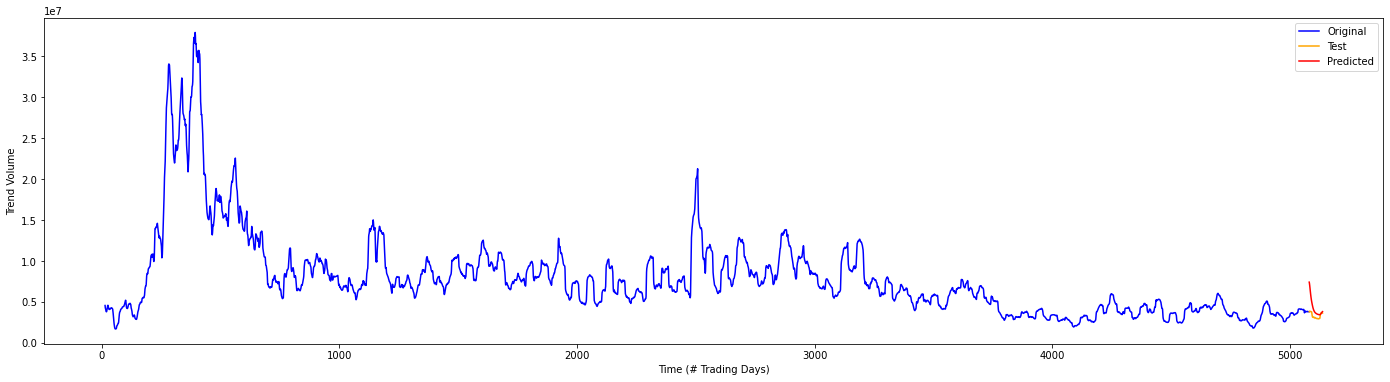

In [135]:
#Plot the predictions and the test data
fig, ax = plt.subplots(figsize=(24,6))
ax.plot(train['trend'], color='blue', label='Original')
ax.plot(df_y_test, color='orange', label='Test')
ax.plot(df_predictions[:60], color='red', label='Predicted')
plt.xlabel('Time (# Trading Days)')
plt.ylabel('Trend Volume')
plt.legend()


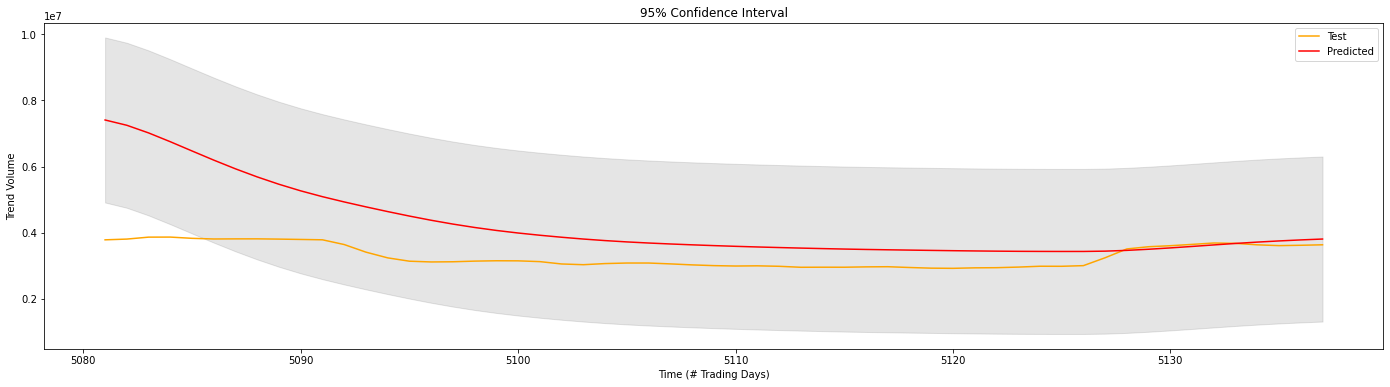

In [136]:
# Plot predictions and uncertainty interval
df_predictions = df_predictions[:60]
fig, ax = plt.subplots(figsize=(24,6))
ax.plot(df_y_test, color='orange', label='Test')
ax.plot(df_predictions[:60], color='red', label='Predicted')
ax.fill_between(df_predictions.index, df_predictions['trend'] - 1.96*rmse, df_predictions['trend'] + 1.96*rmse, color='k', alpha=.1)
plt.xlabel('Time (# Trading Days)')
plt.ylabel('Trend Volume')
plt.title('95% Confidence Interval')
plt.legend()

# Comparrison of Forcasters

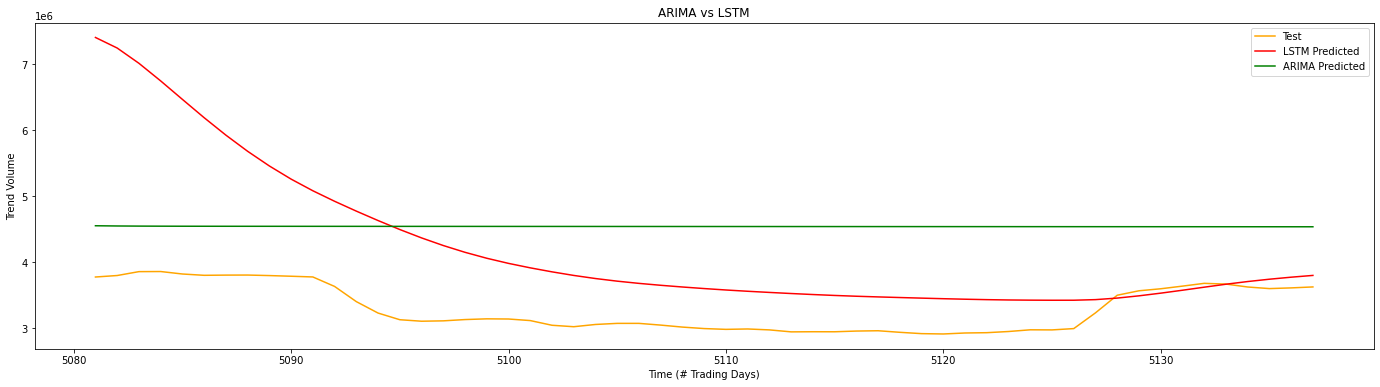

In [137]:
#Compare ARIMA_predictions and df_predictions
fig, ax = plt.subplots(figsize=(24,6))
ax.plot(df_y_test, color='orange', label='Test')
ax.plot(df_predictions[:58], color='red', label='LSTM Predicted')
ax.plot(arima_predictions[1:58], color='green', label='ARIMA Predicted')

#Add legend and title
plt.xlabel('Time (# Trading Days)')
plt.ylabel('Trend Volume')
plt.title('ARIMA vs LSTM')
plt.legend()


In [138]:
df_predictions = df_predictions[:57]

#Make life easier
arima_predictions.columns = ['trend']

**Model vs Actual Data Mean Error**

In [139]:
# Calcualte mean error of each model
arima_error = np.mean(np.abs(arima_predictions[1:58] - df_y_test[:57]))
lstm_error = np.mean(np.abs(df_predictions[:58] - df_y_test[:57]))

#Print the mean errors
print('ARIMA Mean Error: ', arima_error)
print('LSTM Mean Error: ', lstm_error)

ARIMA Mean Error:  trend    1.244218e+06
dtype: float64
LSTM Mean Error:  trend    935024.090058
dtype: float64


**Model vs Moving Average**

In [140]:
maWindow = df['Volume'].rolling(window=120).mean()

arima_ma_differance = arima_predictions[1:58]['trend'] - maWindow[5080:]
lstm_ma_differance = df_predictions[:58]['trend'] - maWindow[5080:]

In [141]:
#Calcualte the difference between the rolling mean and the predictions
arima_error = np.mean(np.abs(arima_predictions[1:58]['trend'] - maWindow[5080:]))
lstm_error = np.mean(np.abs(df_predictions[:58]['trend'] - maWindow[5080:]))

#Print the mean errors
print('ARIMA Mean Error: ', arima_error)
print('LSTM Mean Error: ', lstm_error)

ARIMA Mean Error:  941864.9712880854
LSTM Mean Error:  729463.9210526322


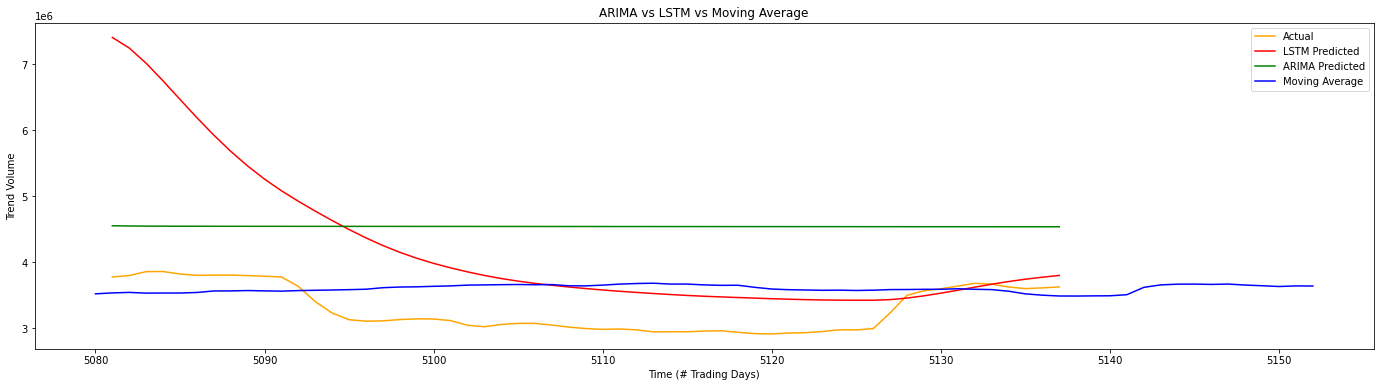

In [142]:
#Graph moving average with predictions
fig, ax = plt.subplots(figsize=(24,6))
ax.plot(df_y_test, color='orange', label='Actual')
ax.plot(df_predictions[:58], color='red', label='LSTM Predicted')
ax.plot(arima_predictions[1:58], color='green', label='ARIMA Predicted')
ax.plot(maWindow[5080:], color='blue', label='Moving Average')
plt.xlabel('Time (# Trading Days)')
plt.ylabel('Trend Volume')
plt.title('ARIMA vs LSTM vs Moving Average')
plt.legend()

Text(0.5, 1.0, 'Effect of Moving Average Window Size on Error')

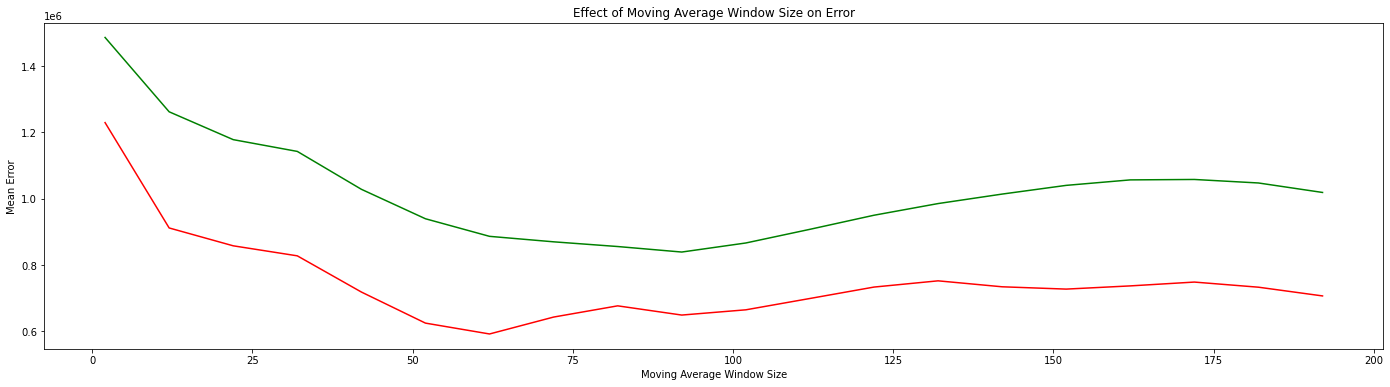

In [143]:
#Calculate the effect of different moving average window sizes on the mean error
windows = []
arima_errors = []
lstm_errors = []

for i in range(2, 200, 10):
    maWindow = df['Volume'].rolling(window=i).mean()
    arima_error = np.mean(np.abs(arima_predictions[1:58]['trend'] - maWindow[5080:]))
    lstm_error = np.mean(np.abs(df_predictions[:58]['trend'] - maWindow[5080:]))
    windows += [i]
    arima_errors += [arima_error]
    lstm_errors += [lstm_error]

#graph the results
fig, ax = plt.subplots(figsize=(24,6))
ax.plot(windows, arima_errors, color='green', label='ARIMA')
ax.plot(windows, lstm_errors, color='red', label='LSTM')
plt.xlabel('Moving Average Window Size')
plt.ylabel('Mean Error')
plt.title('Effect of Moving Average Window Size on Error')

## Future Forcasting Improvements

Both of the models parameters could be fine tuned to suit this task with caution as to prevent overfitting. For the ARIMA the p,d,q values could be further optmized. For the LSTM model the architecture could be improved upon and refined. k-Fold corss validation could also be implemented. More ML model variants could also be used. 